## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [6]:
import torch
import dataset_modules.image_preloader as image_preloader
import main
import importlib
import dataset_modules.preloaded_one_part_dataset as popd

importlib.reload(main)
importlib.reload(popd)

import sklearn
import dataset_modules.common as common
import dataset_modules.preloaded_one_part_dataset as popd
importlib.reload(popd)
importlib.reload(common)

import torchvision.transforms as transforms

## Variables

In [2]:
FEATURE_EXTRACTION = False

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

Usando GPU!


In [3]:
# preload images
preloaded_images = image_preloader.preload_images(
        images_folder='./dataset_modules/imgs/', 
        state_file='./dataset_modules/state.json', 
        resize_to=224
)

Started to preload images...
Image preloading complete in 1m 30s
The preloaded images use 0.07039642333984375MB of memory


In [7]:
import random
import numpy as np

random_state=42

torch.manual_seed(random_state)
random.seed(random_state)
np.random.seed(random_state)

part = "Capot"
MODEL_NAME = "one_part_model-capot"
EXPERIMENT_NAME = "resnet50_capot_augment"

data_augmentation=transforms.Compose([
        #transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
        #transforms.RandomRotation((-45, 45))
        #transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        #transforms.RandomApply([transforms.RandomRotation((-20, 20))], p=0.2),
        #transforms.RandomEqualize(),
        transforms.RandomHorizontalFlip(p=0.5),
    ])

dataset = popd.PreloadedOnePartDataset(
    part,
    preloaded_images,
    remove_not_visible=True,
    ignore_repair=True,
)

y = [y_s for (_,y_s,_) in dataset.samples]
balanced_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=[0,1], y=y)
balanced_weights = torch.tensor(balanced_weights,dtype=torch.float)

"""dataset = popd.PreloadedOnePartDataset(
    part,
    preloaded_images,
    data_augmentation=data_augmentation,
    class_to_augment=0,
    remove_not_visible=True,
    ignore_repair=True
)

"""

----- CLASS DISTRIBUTION -----
Class: capot_sano, #601, 80.24%
Class: capot_roto, #148, 19.76%


'dataset = popd.PreloadedOnePartDataset(\n    part,\n    preloaded_images,\n    data_augmentation=data_augmentation,\n    class_to_augment=0,\n    remove_not_visible=True,\n    ignore_repair=True\n)\n\n'

LOAD TRAIN
----- CLASS DISTRIBUTION -----
Class: capot_sano, #490, 80.07%
Class: capot_roto, #122, 19.93%
LOAD TEST
----- CLASS DISTRIBUTION -----
Class: capot_sano, #111, 81.02%
Class: capot_roto, #26, 18.98%
#TRAIN 612 #TEST 137
Epoch 0/39
----------
train Loss: 0.6948 Main metric (macro_f1): 0.4917 Time: 4.97s
test Loss: 0.6926 Main metric (macro_f1): 0.4794 Time: 0.46s
Epoch 1/39
----------
train Loss: 0.6644 Main metric (macro_f1): 0.5611 Time: 4.51s
test Loss: 0.7042 Main metric (macro_f1): 0.4476 Time: 0.47s
ES Module Best: 0.6926496050653667, BadEpochs: 1
Epoch 2/39
----------
train Loss: 0.6333 Main metric (macro_f1): 0.6342 Time: 4.51s
test Loss: 0.6616 Main metric (macro_f1): 0.5565 Time: 0.47s
ES Module Best: 0.6615803837776184, BadEpochs: 0
Epoch 3/39
----------
train Loss: 0.6008 Main metric (macro_f1): 0.7295 Time: 4.51s
test Loss: 0.6307 Main metric (macro_f1): 0.5933 Time: 0.46s
ES Module Best: 0.6307234720592081, BadEpochs: 0
Epoch 4/39
----------
train Loss: 0.5734 M

,class,precision,recall,f1
0,capot_roto,0.468750,0.576923,0.517241
1,capot_sano,0.895238,0.846847,0.870370


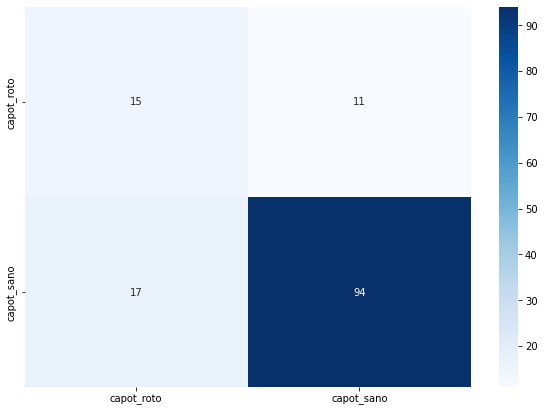

In [8]:
main.train_one_part_model_dataugment(
    part, 
    preloaded_images, 
    MODEL_NAME, 
    EXPERIMENT_NAME, 
    device, 
    feature_extraction=False,
    train_ratio=0.8,
    random_state=42,
    num_epochs=40,
    ignore_repair=True,
    remove_not_visible=True,
    data_augmentation=data_augmentation,
    class_to_augment=0,
    class_weights=balanced_weights,
)